In [1]:
from panoptes_client import Panoptes, Project, SubjectSet, Subject
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import ast
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from PIL import Image
import pickle
import requests
import os
import json
import glob
import datetime as dt
import pandas as pd

In [101]:
subject_url = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/clouds-with-a-type-subjects-20190612.csv'
save_location = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots'

def look_up_url(subject_file, subject_set_id=None):
    """For a given subject file export and subject name, create and return a lookup dict by subject-name to metadata and file locations
    """
    with open(subject_file, 'r') as l_up_file:
        r = csv.DictReader(l_up_file)
        look_up = {}
        subj_ids = dict()
        for row in r:
            if subject_set_id is None:
                if row['subject_set_id'] not in subj_ids.keys():
                    print("new one " + row['subject_set_id'])
                subj_ids[row['subject_set_id']] = subj_ids.setdefault(row['subject_set_id'], 0) + 1
            elif row['subject_set_id'] == subject_set_id:
                s_dict = {}
                s_dict['metadata'] = ast.literal_eval(row['metadata'])
                s_dict['locations'] = ast.literal_eval(row['locations'])
                look_up[row['subject_id']] = s_dict
        if subject_set_id is None:
            print(subj_ids)
        return look_up
    
#TODO FIX THIS
# def download_all_by_granule(name, lookup_dict, basedir=save_location):
#     """For a given granule subject name name (should be something like '30395') and base dir, download every 
#     """
#     savedir = os.path.join(basedir, name)
#     if not os.exists(savedir):
#         os.makedirs(savedir)
#     for k, v in lookup_dict.items():
#         if k[:22] == name:
#             for l_i, url in v['locations']
#                 url = v['locations']['1']
#         gran_url.append(url)
#         r = requests.get(url, allow_redirects=True)
#         savename = os.path.join(r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_1_plots/all_grans', k+'_context.png')
#         open(savename, 'wb').write(r.content)
            
    
def download_one_per_granule(lookup_by_name):
    visited_grans = []
    gran_url = []
    for k,v in lookup_by_name.items():
        gran = v['metadata']['name'][:22]
        if gran not in visited_grans:
            visited_grans.append(gran)
            url = v['locations']['1']
            gran_url.append(url)
            r = requests.get(url, allow_redirects=True)
            savename = os.path.join(save_location, 'all_grans', k+'_context.png')
            open(savename, 'wb').write(r.content)
        
def download_all(lookup_by_subj_id, basedir=save_location, flat=False, save_json=True):
    for k, v in lookup_by_subj_id.items():
        if not flat:
            savedir = os.path.join(basedir, k)
            if not os.path.exists(savedir):
                os.makedirs(savedir)
        else:
            savedir = basedir
        if save_json:
            jsonfile = os.path.join(savedir, k+'.json')
            with open(jsonfile, 'w') as fp:
                json.dump(v, fp)
        for l_i, img_type in zip(['0', '1'], ['scene', 'context']):
            url = v['locations'][l_i]
            fname = v['metadata']['name'] + '.{}.png'.format(img_type)
            r = requests.get(url, allow_redirects=True)
            savename = os.path.join(savedir, fname)
            open(savename, 'wb').write(r.content)


def get_all_subjects_with_same_gran(name, lookup_by_name):
    """get all scenes from the same granule
    """
    gran = name[:22]
    ret_dict = {}
    for k,v in lookup_by_name.items():
        gran_i = k[:22]
        if gran_i == gran:
            ret_dict[k] = v
    return ret_dict
            
def get_all_matching_grans_2(lookup_by_name):
    """get all matching grans for all grans in lookup_by_name 
    """
    count = {}
    for k in lookup_by_name.keys():
        gran_i = k[:22]
        c = count.setdefault(gran_i, 0)
        count[gran_i] = c + 1
    return count

def display_by_name(name, lookup_by_name, img='context'):
    """Displays the image if it has been downloaded
    """
    subj_id = lookup_by_name[name]['subject_id']
    record = read_by_subj(folder=save_location, subject=subj_id)
    img_loc = record['locations'][img]
    img=mpimg.imread(img_loc)
    
    fig, ax = plt.subplots(figsize=(10,10))
    imgplot = ax.imshow(img)
    plt.show()
    

def display_random_image(lookup_by_name, count=1):
    """does what it says
    """
    names = {}
    for i in range(count):
        name, val = random.choice(list(lookup_by_name.items()))
        display_by_name(name, lookup_by_name=lookup_by_name)
        print(name)
        print(val)
        names[i] = name
    return names

def read_by_subj(folder, subject):
    json_file = os.path.join(folder, subject, subject+'.json')
#     print(os.path.join(folder, subject, '*.context.*'))
    context_img_file = glob.glob(os.path.join(folder, subject, '*.context.*'))[0]
    scene_img_file = glob.glob(os.path.join(folder, subject, '*.scene.*'))[0]
    data = json.loads(open(json_file, 'r').read())
    data['locations']['scene'] = scene_img_file
    data['locations']['context'] = context_img_file
    return data

def read_by_name(name, lookup_by_name, folder=save_location):
    subj_id = lookup_by_name[name]['subject_id']
    record = read_by_subj(folder=save_location, subject=subj_id)
    return record
    
def make_manifest(manifest_dict, save_file):
    
                                      manifest = pd.DataFrame([{'name': modis_name, 'date': var_dict['date'], \
                                                            'lat': nearest_upsample(var_dict['lat'])[i+np_x_half, j+np_y_half], \
                                                            'lon': nearest_upsample(var_dict['lon'])[i+np_x_half, j+np_y_half],'i':i,'j':j, \
                                                            'sensor_zenith': sensor_zenith, 'low_cf': low_cf, 'high_cf': high_cf, \
                                                            'refl_img': scene_name, 'context_img': context_name}], \
                                                            columns=('name', 'date', 'lat', 'lon', 'i', 'j', 'sensor_zenith', \
                                                                     'high_cf', 'low_cf', 'refl_img', 'context_img'))
                                  with open(manifest_csv, 'a') as f: manifest.to_csv(f, index=False,header=False) 

            
            

In [26]:
# subject_url = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/clouds-with-a-type-subjects-20190221.csv'
# save_location = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_1_plots'
# subject_url = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/clouds-with-a-type-subjects-20190612.csv'
# save_location = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots'

In [27]:
subject_url

'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/clouds-with-a-type-subjects-20190612.csv'

In [28]:
lookup_by_subj_id = look_up_url(subject_url, subject_set_id=None)

new one 60762
new one 72665
new one 72669
new one 74135
{'60762': 2496, '72665': 163, '72669': 7740, '74135': 24827}


In [29]:
lookup_by_subj_id = look_up_url(subject_url, subject_set_id = '74135')
lookup_by_name = {}
for k,v in lookup_by_subj_id.items():
    new_v = v
    new_v['subject_id'] = k
    lookup_by_name[v['metadata']['name']] = new_v

In [79]:
all_grans = [i['metadata']['name'][:22] for i in lookup_by_subj_id.values()]
all_times = [int(i[18:])/100 for i in all_grans]
all_lats = [float(i['metadata']['lat']) for i in lookup_by_subj_id.values()]
all_lons = [float(i['metadata']['lon']) for i in lookup_by_subj_id.values()]
all_date = [dt.datetime.strptime(i['metadata']['date'][:10], '%Y-%m-%d') for i in lookup_by_subj_id.values()]
all_is = [int(i['metadata']['i']) for i in lookup_by_subj_id.values()]
all_js = [int(i['metadata']['j']) for i in lookup_by_subj_id.values()]
all_cfs = [float(i['metadata']['low_cf']) for i in lookup_by_subj_id.values()]

In [75]:
all_grans[:10]

['MYD02HKM.A2012186.1615',
 'MYD02HKM.A2012015.1930',
 'MYD02HKM.A2012191.1635',
 'MYD02HKM.A2012202.2235',
 'MYD02HKM.A2012110.1415',
 'MYD02HKM.A2012112.0045',
 'MYD02HKM.A2012098.1340',
 'MYD02HKM.A2012029.2325',
 'MYD02HKM.A2012303.1450',
 'MYD02HKM.A2012292.1505']

In [60]:
good_gran_dir = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots/good_grans'
good_gran_file_names = os.listdir(good_gran_dir)
good_grans = np.array([i[:22] for i in os.listdir(good_gran_dir)])
np.savez(r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots/good_granule_list.npz', granules=good_grans)

In [76]:
good_index = [True if i in good_grans else False for i in all_grans]

In [102]:
good_dict = {k:v for k,v in lookup_by_subj_id.items() if v['metadata']['name'][:22] in good_grans}
# download_all(good_dict, basedir = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots/all_good_subjects', flat=True, save_json=True)

In [123]:
good_df = pd.DataFrame({k: v['metadata'] for k, v in good_dict.items()}).T
csvfile = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_2_plots/good_manifest.csv'
good_df.to_csv(csvfile, index=False)


In [122]:
good_df.loc['31650763']

context_img      MYD02HKM.A2012012.2240.061_index_0256_index_20...
date                                           2012-01-12 22:40:00
granule                                     MYD02HKM.A2012012.2240
high_cf                                                0.119140625
i                                                              256
j                                                             2048
lat                                                  36.0580291748
lon                                                 -137.969512939
low_cf                                                         1.0
name              MYD02HKM.A2012012.2240.061_index_0256_index_2048
refl_img         MYD02HKM.A2012012.2240.061_index_0256_index_20...
sensor_zenith                                                37.78
Name: 31650763, dtype: object

In [116]:
good_dict['31657431']

{'locations': {'0': 'https://panoptes-uploads.zooniverse.org/production/subject_location/12e5f5f5-83a3-4357-9138-25c32e53a0c0.png',
  '1': 'https://panoptes-uploads.zooniverse.org/production/subject_location/e6ec11d0-f1e2-4627-bd13-c8c2ac773025.png'},
 'metadata': {'context_img': 'MYD02HKM.A2012109.2145.061_index_2048_index_1280.context.png',
  'date': '2012-04-18 21:45:00',
  'granule': 'MYD02HKM.A2012109.2145',
  'high_cf': '0.0',
  'i': '2048',
  'j': '1280',
  'lat': '26.507703781100002',
  'lon': '-126.69582366899999',
  'low_cf': '0.845458984375',
  'name': 'MYD02HKM.A2012109.2145.061_index_2048_index_1280',
  'refl_img': 'MYD02HKM.A2012109.2145.061_index_2048_index_1280.scene.png',
  'sensor_zenith': '2.52'},
 'subject_id': '31657431'}

In [107]:
good_df

,31650763,31650764,31650765,31650766,31650767,31650768,31650769,31650770,31650771,31650772,...,31673887,31673888,31673889,31673890,31673891,31673892,31673893,31673894,31673895,31673896
locations,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...,{'0': 'https://panoptes-uploads.zooniverse.org...
metadata,"{'j': '2048', 'lon': '-137.969512939', 'granul...","{'j': '2048', 'lon': '-137.720779419', 'granul...","{'j': '1792', 'lon': '-139.081085205', 'granul...","{'j': '2048', 'lon': '-137.231628418', 'granul...","{'j': '1792', 'lon': '-138.815795898', 'granul...","{'j': '2048', 'lon': '-136.989776611', 'granul...","{'j': '1792', 'lon': '-138.552246094', 'granul...","{'j': '2048', 'lon': '-136.748519897', 'granul...","{'j': '256', 'lon': '-147.39289856', 'granule'...","{'j': '1280', 'lon': '-141.085754395', 'granul...",...,"{'j': '512', 'lon': '-151.1180877685547', 'gra...","{'j': '768', 'lon': '-146.73182678222656', 'gr...","{'j': '1024', 'lon': '-143.11915588378906', 'g...","{'j': '512', 'lon': '-150.07582092285156', 'gr...","{'j': '768', 'lon': '-145.45846557617188', 'gr...","{'j': '1024', 'lon': '-141.67529296875', 'gran...","{'j': '1280', 'lon': '-138.29875183105472', 'g...","{'j': '512', 'lon': '-148.927734375', 'granule...","{'j': '768', 'lon': '-144.04833984375', 'granu...","{'j': '1024', 'lon': '-140.07608032226562', 'g..."
subject_id,31650763,31650764,31650765,31650766,31650767,31650768,31650769,31650770,31650771,31650772,...,31673887,31673888,31673889,31673890,31673891,31673892,31673893,31673894,31673895,31673896


In [188]:
sum(good_index)

2652

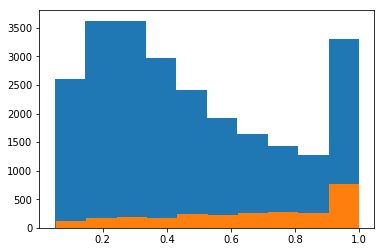

In [124]:
plt.hist(all_cfs)
plt.hist(np.array(all_cfs)[good_index]);

In [39]:
# download_one_per_granule(lookup_by_name)

In [125]:
Panoptes.connect(username='jmohrmann', password='qwerty12345')

In [146]:
project = Project.find(slug='cloud-class/clouds-with-a-type')
# for workflow in project.links.workflows:
#     print(workflow.display_name)
# for subject_set in project.links.subject_sets:
#     print(subject_set.display_name)
new_subject_set = SubjectSet.find(76361)
old_subject_set = SubjectSet.find(74135)

In [177]:
good_ids = [int(i) for i in good_dict.keys()]

In [169]:
all_old_ids = [int(i) for i in all_old_ids]

In [178]:
intersect = set(all_old_ids).intersection(good_ids)

In [ ]:

    subject = Subject()

    subject.links.project = tutorial_project
    subject.add_location(filename)

    subject.metadata.update(metadata)

    subject.save()
    new_subjects.append(subject)

Number of processors:  8


In [187]:
i=0 # matches found
good_ids = set([int(i) for i in good_dict.keys()])
subjects_to_link = []
for j, subject in enumerate(old_subject_set.subjects): 
    if j%1000 ==0:
        print("j: " + str(j))
#     all_old_ids.append(subject.id)
#     if j<10:
#         print(subject.id)
    if int(subject.id) in good_ids:
        subjects_to_link.append(subject)
        i+=1
        if i<10:
            print(i)
        if i%100 == 0 and i>0:
            print(i)

new_subject_set.add(subjects_to_link)

j: 0
j: 1000
1
2
3
4
5
6
7
8
9
100
j: 2000
200
j: 3000
300
400
500
j: 4000
600
700
j: 5000
800
j: 6000
j: 7000
900
j: 8000
1000
1100
j: 9000
1200
1300
j: 10000
j: 11000
1400
1500
j: 12000
j: 13000
1600
j: 14000
1700
j: 15000
1800
j: 16000
j: 17000
1900
j: 18000
2000
2100
j: 19000
2200
j: 20000
2300
2400
j: 21000
j: 22000
2500
j: 23000
j: 24000
2600


In [ ]:
good_dict

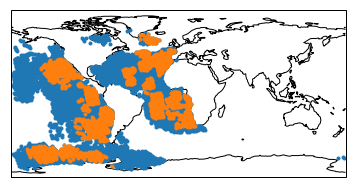

In [90]:
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': crs})
# ax.set_extent([-150, -60, -40, 10])
# ax.stock_img()
ax.coastlines(resolution='110m')
ax.plot(all_lons, all_lats, '.', transform=ccrs.PlateCarree())

ax.plot(np.array(all_lons)[good_index], np.array(all_lats)[good_index], '.', transform=ccrs.PlateCarree())

ax.set_global()
# ax.plot(all_lons, all_lats, '.', transform=crs)

# ax.set_xlim([-140, -110])


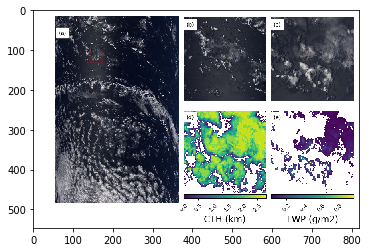

In [151]:
url = lookup_by_name['MYD02HKM.A2012009.2015.061_index_0768_index_0768']['locations']['1']
im = Image.open(requests.get(url, stream=True).raw)
plt.axis([0.0, im.size[0], im.size[1], 0.0])
plt.imshow(im)

In [222]:
v = lookup_by_subj_id['30397460']
floc = r'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_1_plots/test.json'
with open(floc, 'w') as fp:
#     json.dump(v, fp)
    pass


In [152]:
lookup_by_name['MYD02HKM.A2012009.2015.061_index_0768_index_0768']

{'locations': {'0': 'https://panoptes-uploads.zooniverse.org/production/subject_location/bbe4c9bc-574f-4501-b9cb-0482f63b21d7.png',
  '1': 'https://panoptes-uploads.zooniverse.org/production/subject_location/ba6c3201-97e2-4235-88dd-5605fe3e818d.png'},
 'metadata': {'context_img': 'MYD02HKM.A2012009.2015.061_index_0768_index_0768.context.png',
  'date': '2012-01-09 20:15:00',
  'high_cf': '0.0',
  'i': '768',
  'j': '768',
  'lat': '-22.2270965576',
  'lon': '-99.9428482056',
  'low_cf': '0.784545898438',
  'name': 'MYD02HKM.A2012009.2015.061_index_0768_index_0768',
  'refl_img': 'MYD02HKM.A2012009.2015.061_index_0768_index_0768.scene.png',
  'sensor_zenith': '20.73'},
 'subject_id': '30398239'}

In [23]:
# read_by_subj(folder=save_location, subject='30396037')

# lookup_by_name['MYD02HKM.A2012001.2240.061_index_3584_index_1024'] # open cell by context?
# lookup_by_name['MYD02HKM.A2012022.1945.061_index_0768_index_0768'] # agg by context?
# lookup_by_name['MYD02HKM.A2012008.1930.061_index_1280_index_1792'] # no dominant type example
# lookup_by_name['MYD02HKM.A2012023.2030.061_index_2816_index_2048'] # most of granule is agg
# lookup_by_name['MYD02HKM.A2012024.2115.061_index_0512_index_1792'] # lots of suppressed in granule
# lookup_by_name['MYD02HKM.A2012018.1830.061_index_2304_index_0512'] # finally some closed-cell
# 'MYD02HKM.A2012019.1915.061_index_1536_index_1536' # some agg in the middle of some suppressed?
# 'MYD02HKM.A2012014.2215.061_index_0256_index_0256' # awesome scene with mostly suppressed, rivers of organization
# 'MYD02HKM.A2012009.2015.061_index_0768_index_0768' # granule shows transition, scene is probably aggregated

# name = 'MYD02HKM.A2012009.2015.061_index_0768_index_0768'
# lookup_by_name['MYD02HKM.A2012031.1935.061_index_2304_index_1280']
# lookup_by_name['MYD02HKM.A2012001.2240.061_index_3584_index_0768']
# lookup_by_name['MYD02HKM.A2012013.1950.061_index_1024_index_1536']

#new set:
#MYD02HKM.A2012029.2135.061_index_1024_index_1792 cool cloud streets, suppressed
#MYD02HKM.A2012016.2205.061_index_3328_index_2048 clustered 
#MYD02HKM.A2012016.2205.061_index_0768_index_2048 solid stratus
#MYD02HKM.A2012016.2205.061_index_0768_index_0768 solid stratus
#MYD02HKM.A2012005.1900.061_index_3328_index_1536 more solid stratus

#MYD02HKM.A2012002.1830.061_index_3328_index_0256 cloud EDGE, clear
# MYD02HKM.A2012023.1850.061_index_3072_index_1536 suppressed with speckling
# MYD02HKM.A2012015.1940.061_index_2304_index_0512 sun glint artefacts

# MYD02HKM.A2012026.1920.061_index_1024_index_0512 clustered cu
# MYD02HKM.A2012015.1940.061_index_1536_index_0768 SUN GLINT
# MYD02HKM.A2012015.1940.061_index_3328_index_1024 DISORGN

In [144]:
read_by_name('MYD02HKM.A2012022.1950.061_index_3072_index_1792', lookup_by_name)['locations']['context']

'/home/disk/eos4/jkcm/Data/MEASURES/zooniverse/set_1_plots/30400497/MYD02HKM.A2012022.1950.061_index_3072_index_1792.context.png'

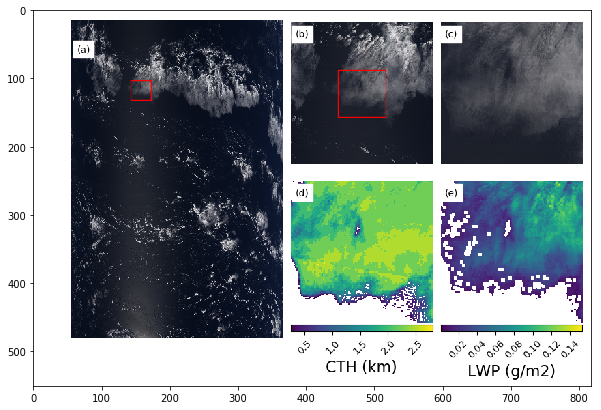

In [135]:
display_by_name('MYD02HKM.A2012016.2205.061_index_0768_index_0768', lookup_by_name)

In [ ]:
name = display_random_image(lookup_by_name, 10)

In [132]:

# get_all_matching_grans(name).keys() get all images with matching granule
count = get_all_matching_grans_2() # get count of all matching grans for all grans

TypeError: get_all_matching_grans_2() missing 1 required positional argument: 'lookup_by_name'

{'miss_02': [], 'miss_03': ['A2015182.0225'], 'miss_06': []}

In [34]:
#if day HDF is complete, then can go ahead and process it to npz. 
#if npz list if complete, then can go ahead and delete HDF 
#if HDF delete is complete, can go ahead and process every npz
#if npz process is complete, can go ahead and add it to the bigger archive.


ValueError: invalid number of arguments